## 1. 실험환경 set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 윈도우용 home
#from pathlib import Path
#home = str(Path.home())

In [3]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해 볼 것
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 준비하기
- augmentation 기법 고려

In [4]:
# 데이터 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train data, validation data 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다. 
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# 정상과 폐렴 구분
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Pneumonia images count in training set: {COUNT_PNEUMONIA}')

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### tf.data 인스턴스 생성

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# train dataset, validation dataset 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


#### 라벨 데이터 만들어주는 함수 생성

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 TRUE, 아니면 FALSE

In [10]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 알맞은 형식으로 수정
    return img, label

####  train 데이터셋과 validation 데이터셋 만들기

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image,label in train_ds.take(1):
    print('image shape: ', image.numpy().shape)
    print('label: ', label.numpy())

image shape:  (180, 180, 3)
label:  False


In [13]:
# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### 좌우반전 augmentation 기법 도입해보기

In [14]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    #ds = ds.map(augment, #augment 함수 적용
     #          num_parallel_calls=2
      #         )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

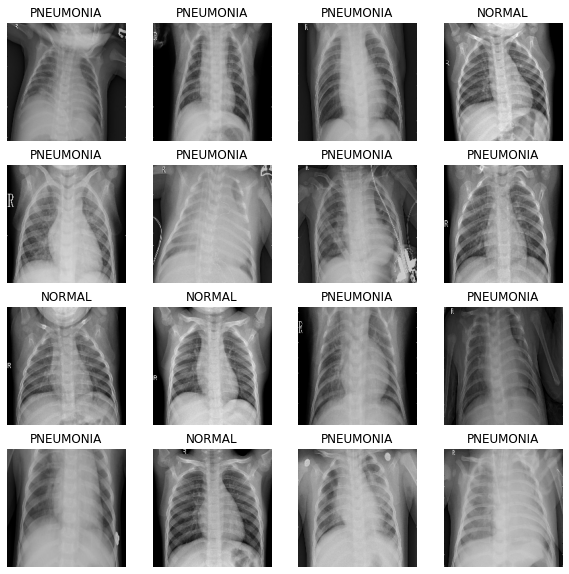

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128), 
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics=METRICS)

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds,
                       steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
                       epochs = EPOCHS,
                       validation_data = val_ds,
                       validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
                       class_weight = class_weight,
                       )

Epoch 1/25
261/261 [==============================] - 89s 206ms/step - loss: 0.4041 - accuracy: 0.8173 - precision: 0.9497 - recall: 0.7965 - val_loss: 0.7024 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 53s 205ms/step - loss: 0.2392 - accuracy: 0.9076 - precision: 0.9690 - recall: 0.9048 - val_loss: 1.2343 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 54s 206ms/step - loss: 0.2115 - accuracy: 0.9191 - precision: 0.9746 - recall: 0.9149 - val_loss: 0.2164 - val_accuracy: 0.8942 - val_precision: 0.8767 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 55s 209ms/step - loss: 0.1860 - accuracy: 0.9315 - precision: 0.9777 - recall: 0.9292 - val_loss: 0.1077 - val_accuracy: 0.9558 - val_precision: 0.9545 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 56s 214ms/step - loss: 0.1685 - accura

## 7. 결과확인과 시각화

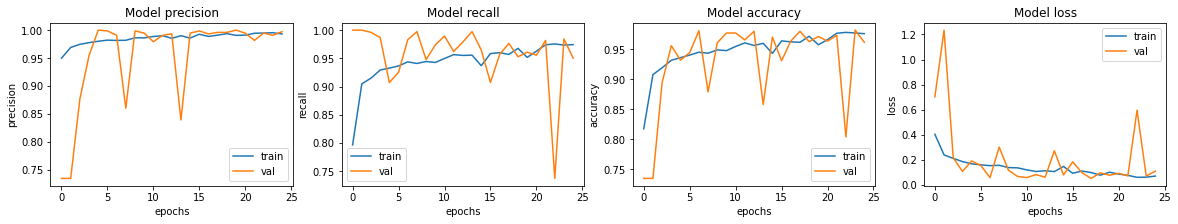

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 0.6609 - accuracy: 0.8590 - precision: 0.8283 - recall: 0.9769
Loss: 0.6609183549880981, 
Accuracy: 0.8589743375778198, 
Precision: 0.8282608985900879, 
Recall: 0.9769230484962463


In [ ]:
'''
>>augmentation 미포함 결과<<
39/39 [==============================] - 11s 271ms/step - loss: 0.4312 - accuracy: 0.8750 - precision: 0.8805 - recall: 0.9256
Loss: 0.431181401014328, 
Accuracy: 0.875, 
Precision: 0.8804877996444702, 
Recall: 0.9256410002708435

>>> dropout 제거한 결과<<<
39/39 [==============================] - 5s 115ms/step - loss: 0.9338 - accuracy: 0.8285 - precision: 0.7930 - recall: 0.9821
Loss: 0.9337739944458008, 
Accuracy: 0.8285256624221802, 
Precision: 0.7929606437683105, 
Recall: 0.9820512533187866

>>>epoch 20으로 줄였을 때<<<
39/39 [==============================] - 5s 116ms/step - loss: 0.4690 - accuracy: 0.8574 - precision: 0.8397 - recall: 0.9538
Loss: 0.46901679039001465, 
Accuracy: 0.8573718070983887, 
Precision: 0.8397291302680969, 
Recall: 0.9538461565971375

------------------------------------------------------------

>>augmentation 포함 결과<<
39/39 [==============================] - 5s 115ms/step - loss: 1.8341 - accuracy: 0.6571 - precision: 0.6457 - recall: 1.0000
Loss: 1.8340774774551392, 
Accuracy: 0.6570512652397156, 
Precision: 0.6456953883171082, 
Recall: 1.0

>>> dropout 제거한 결과<<<
39/39 [==============================] - 5s 123ms/step - loss: 0.8812 - accuracy: 0.8349 - precision: 0.8008 - recall: 0.9795
Loss: 0.8812152147293091, 
Accuracy: 0.8349359035491943, 
Precision: 0.8008385896682739, 
Recall: 0.9794871807098389

>>> batch normalization 제거 결과<<<
# 얘는 버려야 할 듯. 

>>> epoch 20으로 줄였을 때<<<
조금 나아짐 . 약 70% 정도
'''

1. 일단 처음에 augmentation을 포함하지 않은 상태에서는 loss값도 낮았고, 87% 정확도에 90%가 넘는 recall 값을 가졌기 때문에 결과가 좋았다고 볼 수 있다. 
2. 하지만 augmentation을 도입한 후 수치가 확 떨어졌다. loss값은 1을 넘고, recall은 1이 나왔다. 
3. 그래서 dropout을 제거하고 다시 돌려봤다. 이전보다 확실히 나아졌다. 혹시 dropout과 normalization 중 하나만 써서 그런가 싶어서
4. batch normalization도 제거하고 돌려봤는데, 학습과정에서 recall값이 어느순간부터 계속 1이 나오기 시작했다. 아마 다 폐렴에 걸렸다고 예측을 한건가 싶어 뭔가 잘못됐구나 싶었다. 
5. 이번엔 epoch를 20으로 줄여봤다. 5 정도 줄인다고 수치가 많이 달라질까 싶었는데, 테스트 결과는 나쁘지 않았다.
6. augmentation을 빼고 처음 상태에서 다시 epoch를 20으로 줄여봤는데 이 결과도 나쁘지 않지만 loss값이 큰 것을 볼 수 있었다.
<br><br>

결과가 가장 좋았던 것은 노드에 나온 그대로, augmentation을 포함하지 않은 모델이었다. <br>

다시 돌려보니 epoch 20으로 돌린 모델이 더 나은 것 같다.<br>
Loss: 0.46901679039001465, <br>
Accuracy: 0.8573718070983887, <br>
Precision: 0.8397291302680969, <br>
Recall: 0.9538461565971375<br>

<br><br>
이번 노드에서 정규화 기법 두 개(dropout, batch normalization)를 같이 썼는데, 모델을 돌리면서 성능이 어떻게 달라질까 궁금해 dropout을 제외하고 돌려보기도 하고, batch normalization을 제외하고 돌려보기도 했다. 신기한 점은 dropout을 제거했을 때는 성능이 일부 나아지기도 한 반면, batch normalization을 제외했을 때에는 값이 정말 엉망으로 나왔다. 모델은 건드리지 않고 제외만 시켜서 그럴지도 모른다. <br>
오늘은 이것저것 만져보기만 했지만, 앞으로 dropout과 batch normalization에 대해 더 공부해보고 다시 적용시켜봐야겠다.